Found 840 images belonging to 7 classes.
Found 210 images belonging to 7 classes.
Labels map: {0: '10', 1: '100', 2: '20', 3: '200', 4: '2000', 5: '50', 6: '500'}
Epoch 1/200
27/27 [==============================] - 29s 1s/step - loss: 1.9823 - accuracy: 0.3988 - val_loss: 0.9278 - val_accuracy: 0.6905
Epoch 2/200
27/27 [==============================] - 28s 1s/step - loss: 0.8315 - accuracy: 0.6845 - val_loss: 0.4238 - val_accuracy: 0.8095
Epoch 3/200
27/27 [==============================] - 27s 999ms/step - loss: 0.5697 - accuracy: 0.8000 - val_loss: 0.4065 - val_accuracy: 0.8619
Epoch 4/200
27/27 [==============================] - 25s 916ms/step - loss: 0.5087 - accuracy: 0.8310 - val_loss: 0.2398 - val_accuracy: 0.9476
Epoch 5/200
27/27 [==============================] - 30s 1s/step - loss: 0.3173 - accuracy: 0.8976 - val_loss: 0.1245 - val_accuracy: 0.9714
Epoch 6/200
27/27 [==============================] - 23s 835ms/step - loss: 0.2731 - accuracy: 0.9262 - val_loss: 0.1697 - val

C:\Users\prave\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


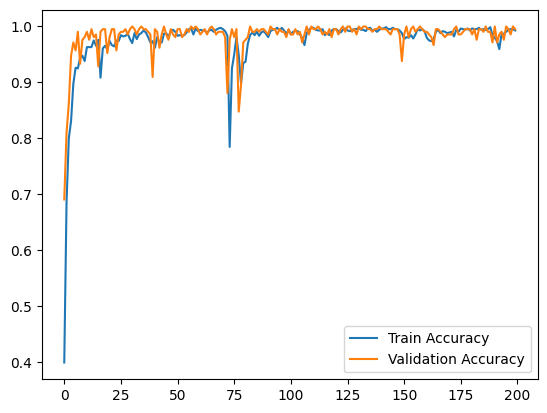

In [2]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Define the path
data_dir = 'data'  # Your dataset folder

# Parameters
img_height, img_width = 224, 224
batch_size = 32
epochs = 200

# Data Augmentation for Robustness
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Train set
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='training',
    shuffle=True
)

# Validation set
val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse',
    subset='validation',
    shuffle=True
)

# Save the mapping of class indices
class_indices = train_generator.class_indices
labels_map = {v: k for k, v in class_indices.items()}
print("Labels map:", labels_map)

# Building a Strong CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_indices), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

# Save the model
model.save('currency_detector_model.h5')

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


In [6]:
import cv2
import numpy as np
import pyttsx3
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model('currency_detector_model.h5')

# Labels Map (make sure this matches your training labels!)
labels_map = {0: '10 Rupees', 1: '20 Rupees', 2: '50 Rupees', 3: '100 Rupees', 4: '200 Rupees', 5: '500 Rupees', 6: '2000 Rupees'}

# Text-to-Speech Engine
engine = pyttsx3.init()

# Webcam
cap = cv2.VideoCapture(0)

# Parameters
img_height, img_width = 224, 224

print("📷 Press SPACE to capture the image for detection...")
print("❌ Press ESC to exit without detection.")

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Show the live feed
    cv2.imshow('Currency Detector - Press SPACE to Capture', frame)

    key = cv2.waitKey(1)

    if key % 256 == 27:
        # ESC pressed -> exit
        print("❌ Escape hit, closing...")
        break

    elif key % 256 == 32:
        # SPACE pressed -> capture
        img = cv2.resize(frame, (img_height, img_width))
        img = img/255.0
        img = np.expand_dims(img, axis=0)

        # Predict
        pred = model.predict(img)
        pred_class = np.argmax(pred)
        confidence = np.max(pred)

        denomination = labels_map[pred_class]

        if confidence > 0.80:
            print(f"✅ Detected: {denomination} (Confidence: {confidence*100:.2f}%)")
            engine.say(f"This is {denomination}")
            engine.runAndWait()
        else:
            print("⚠️ Unable to detect with high confidence. Please try again.")
            engine.say("Unable to detect clearly. Please try again.")
            engine.runAndWait()

        break  # After one detection, exit

cap.release()
cv2.destroyAllWindows()


📷 Press SPACE to capture the image for detection...
❌ Press ESC to exit without detection.
1/1 [==============================] - 0s 100ms/step
✅ Detected: 500 Rupees (Confidence: 99.79%)
